In [1]:
import pandas as pd
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from itertools import combinations

### Data Extraction
Output:   actual_systole, actual_diastole, age, weigth, bpm, ibi, ..."PPG Feature"

In [2]:
data = pd.read_csv('data-clean.csv')
data_extraction = pd.DataFrame()

for i, ppg in enumerate(data['ppg']): 
  ppg = list(map(int, ppg.split(',')))

  try:
    data_extraction.at[i, 'actual_systole'] = data.at[i, 'actual_systole']
    data_extraction.at[i, 'actual_diastole'] = data.at[i, 'actual_diastole']
    data_extraction.at[i, 'age'] = data.at[i, 'age']
    data_extraction.at[i, 'weight'] = data.at[i, 'weight']
    wd, m = hp.process(np.array(ppg), sample_rate = 100.0)
    for key, value in m.items():
      data_extraction.at[i, key] = value
  except Exception as e:
    print(f"{i} - {e}")
    
data_extraction = data_extraction.dropna()
data_extraction.to_csv('data-extraction.csv', index = False)

c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Python310\lib\site-packages\scipy\interpolate\_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


### Normalization

In [3]:
data = pd.read_csv('data-extraction.csv')

bp = pd.DataFrame()
bp['actual_systole'] = data.pop('actual_systole')
bp['actual_diastole'] = data.pop('actual_diastole')

# Create a StandardScaler
standard_scaler = StandardScaler()

# Fit the scaler and transform the data
X_scaler = standard_scaler.fit(data)
joblib.dump(X_scaler, 'scaler.pkl')

standardized_data = pd.DataFrame(X_scaler.transform(data))
standardized_data.columns = data.columns

concatenated_df = pd.concat([bp, standardized_data], axis=1)

concatenated_df.to_csv('data-extraction-normalized.csv', index=False)

# Training

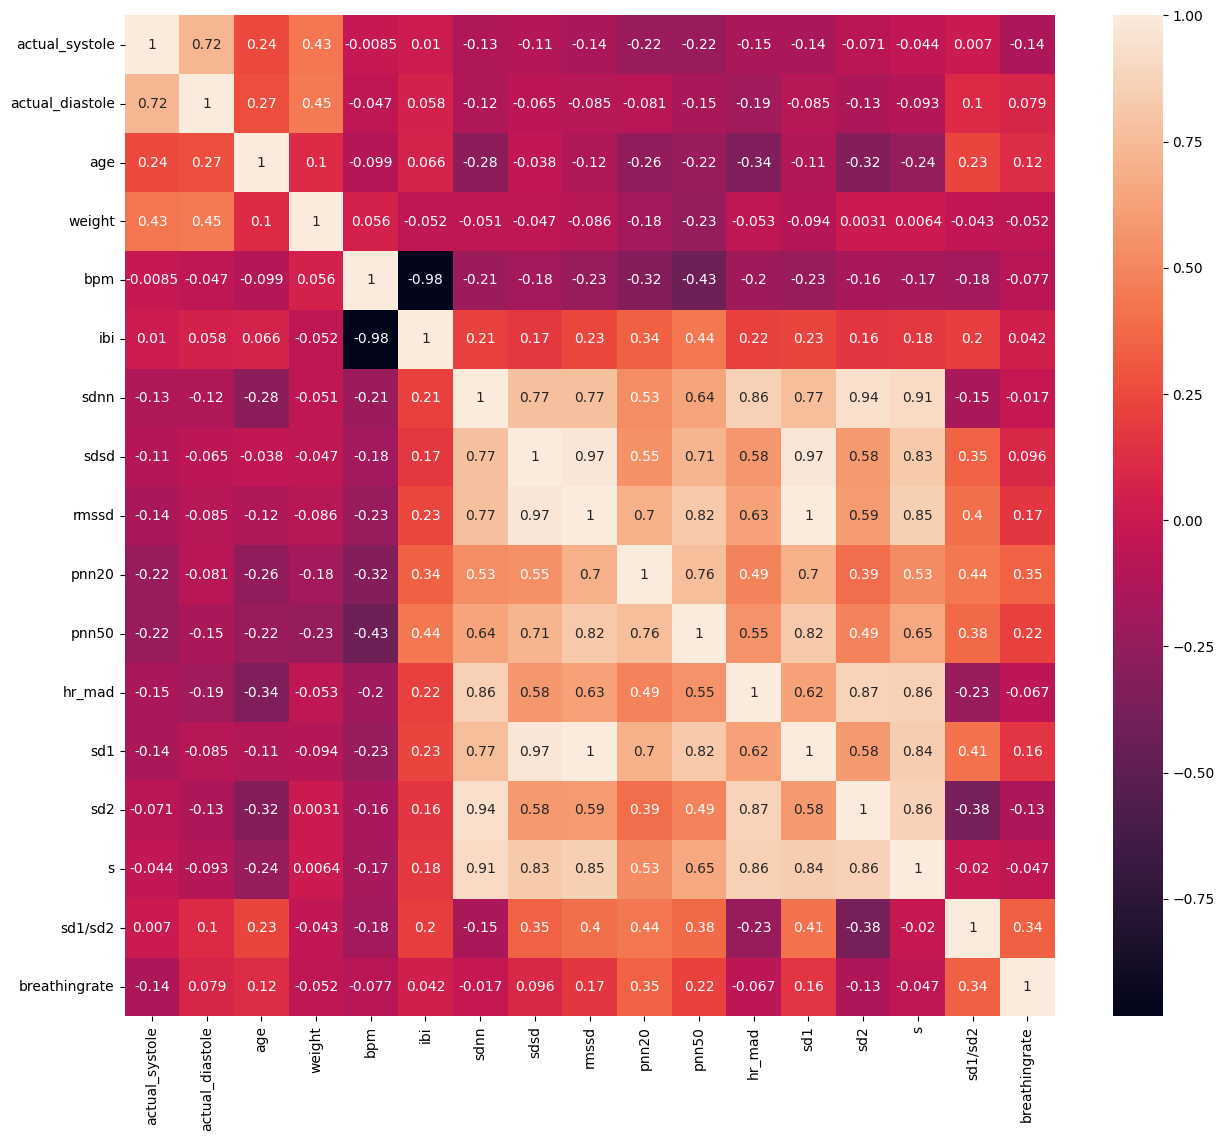

In [14]:
data = pd.read_csv('data-extraction-normalized.csv')

# Correlation Matrix between variable
corr_matrix = data.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Sorting Best features for systole 

# get systole correlation matrix
systole_corr_matrix = dict(corr_matrix["actual_systole"])
# abs() for all member
systole_corr_matrix = {key: abs(value) for key, value in systole_corr_matrix.items()}
# sort the systole corr matrix
sorted_systole_corr_matrix = dict(sorted(systole_corr_matrix.items(), key=lambda item: item[1], reverse=True))
# get the keys of sorted best feature
sorted_feature_systole = list(sorted_systole_corr_matrix.keys())

# Sorting Best features for diastole 

# get diastole correlation matrix
diastole_corr_matrix = dict(corr_matrix["actual_diastole"])
# abs() for all member
diastole_corr_matrix = {key: abs(value) for key, value in diastole_corr_matrix.items()}
# sort the diastole corr matrix
sorted_diastole_corr_matrix = dict(sorted(diastole_corr_matrix.items(), key=lambda item: item[1], reverse=True))
# get the keys of sorted best feature
sorted_feature_diastole = list(sorted_diastole_corr_matrix.keys())

# systole training
for i in range(len(sorted_feature_systole)-2):
  # get X and y
  X = np.array([data[feature] for feature in sorted_feature_systole[2:i+3]])
  X = X.transpose()
  y = data["actual_systole"]

  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Define the SVR model
  svr = SVR(kernel='rbf')

  # Define the parameter grid for hyperparameter tuning
  param_grid = {'C': [1,2,3,4,6,8,10,15,20,25,30,35,40,50,60,70,80,100,150,200,250,300,350,400], 'epsilon': [0.1,0.2,0.3,0.4,0.6,0.8,1,1.5,2,2.5,3,3.5,4,5,6,7,8,10,15,20,25,30]}

  # Create the GridSearchCV object
  grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')

  # Fit the model with the training data
  grid_search.fit(X_train, y_train)

  joblib.dump(grid_search, f"grid-search-result/systole/{i}.pkl")

# diastole training
for i in range(len(sorted_feature_diastole)-2):
  # get X and y
  X = np.array([data[feature] for feature in sorted_feature_diastole[2:i+3]]).transpose()
  y = data["actual_diastole"]

  # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Define the SVR model
  svr = SVR(kernel='rbf')

  # Define the parameter grid for hyperparameter tuning
  param_grid = {'C': [1,2,3,4,6,8,10,20,30,40,60,70,80,100,200,300,400], 'epsilon': [0.1,0.2,0.3,0.4,0.6,0.8,1,2,3,4,6,8,10,15,20]}

  # Create the GridSearchCV object
  grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_absolute_error')

  # Fit the model with the training data
  grid_search.fit(X_train, y_train)

  joblib.dump(grid_search, f"grid-search-result/diastole/{i}.pkl")
  


# Search best model

C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


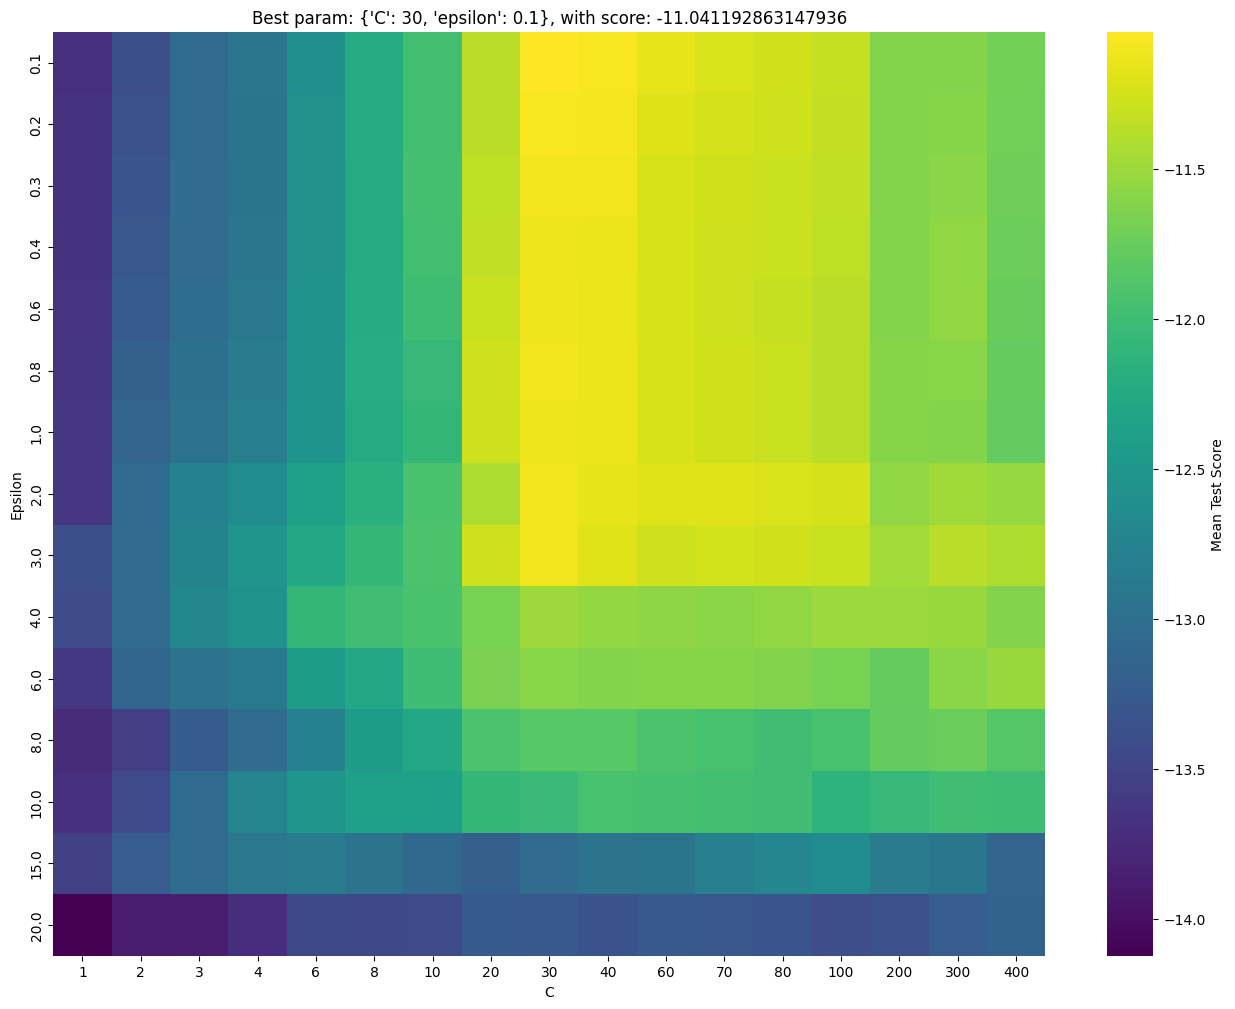

Best hyperparameters: {'C': 30, 'epsilon': 0.1}
With Score: -11.041192863147936


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


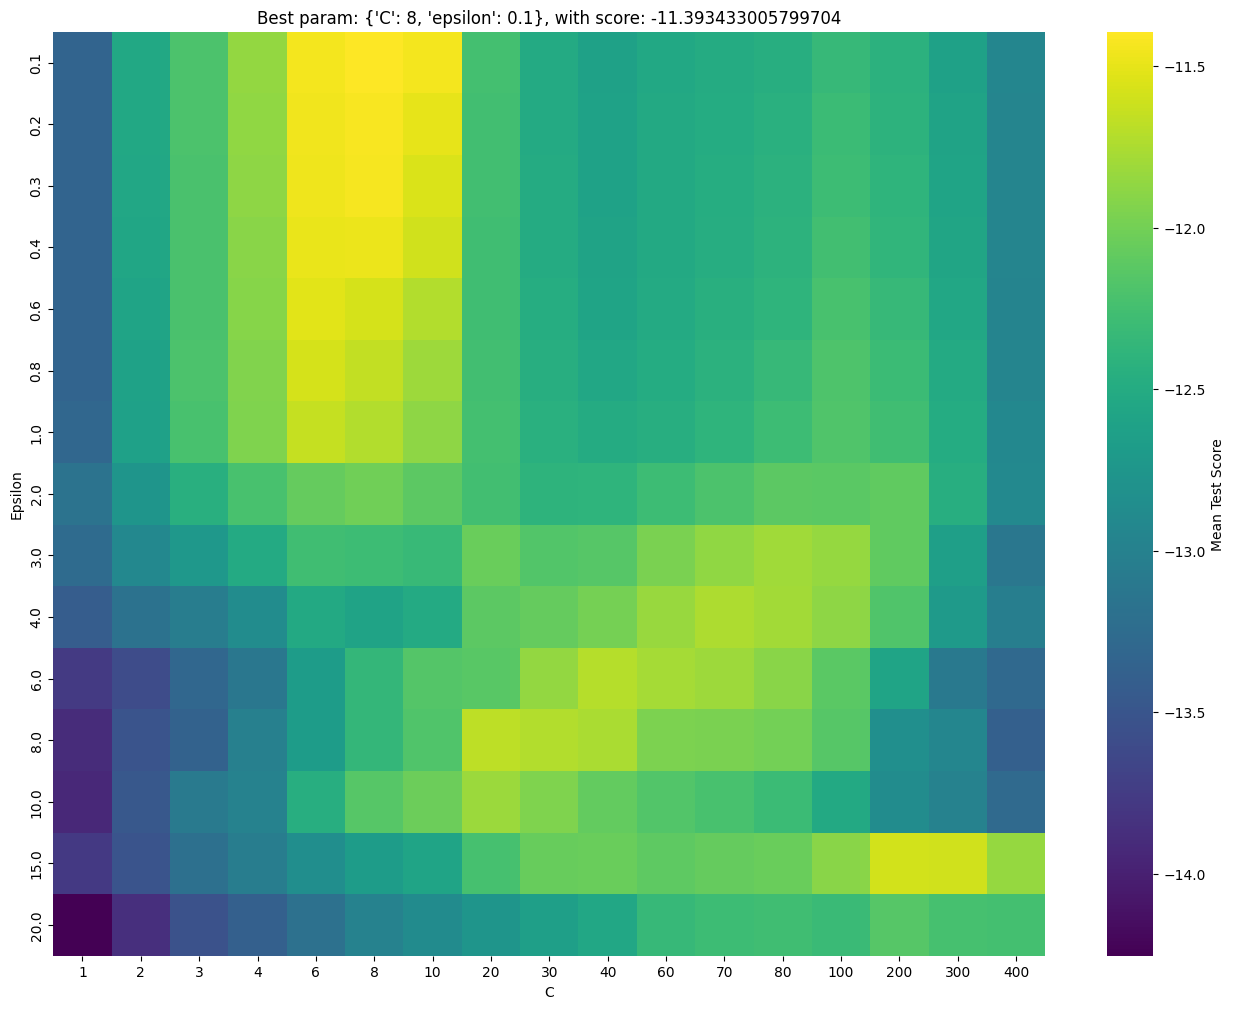

Best hyperparameters: {'C': 8, 'epsilon': 0.1}
With Score: -11.393433005799704


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


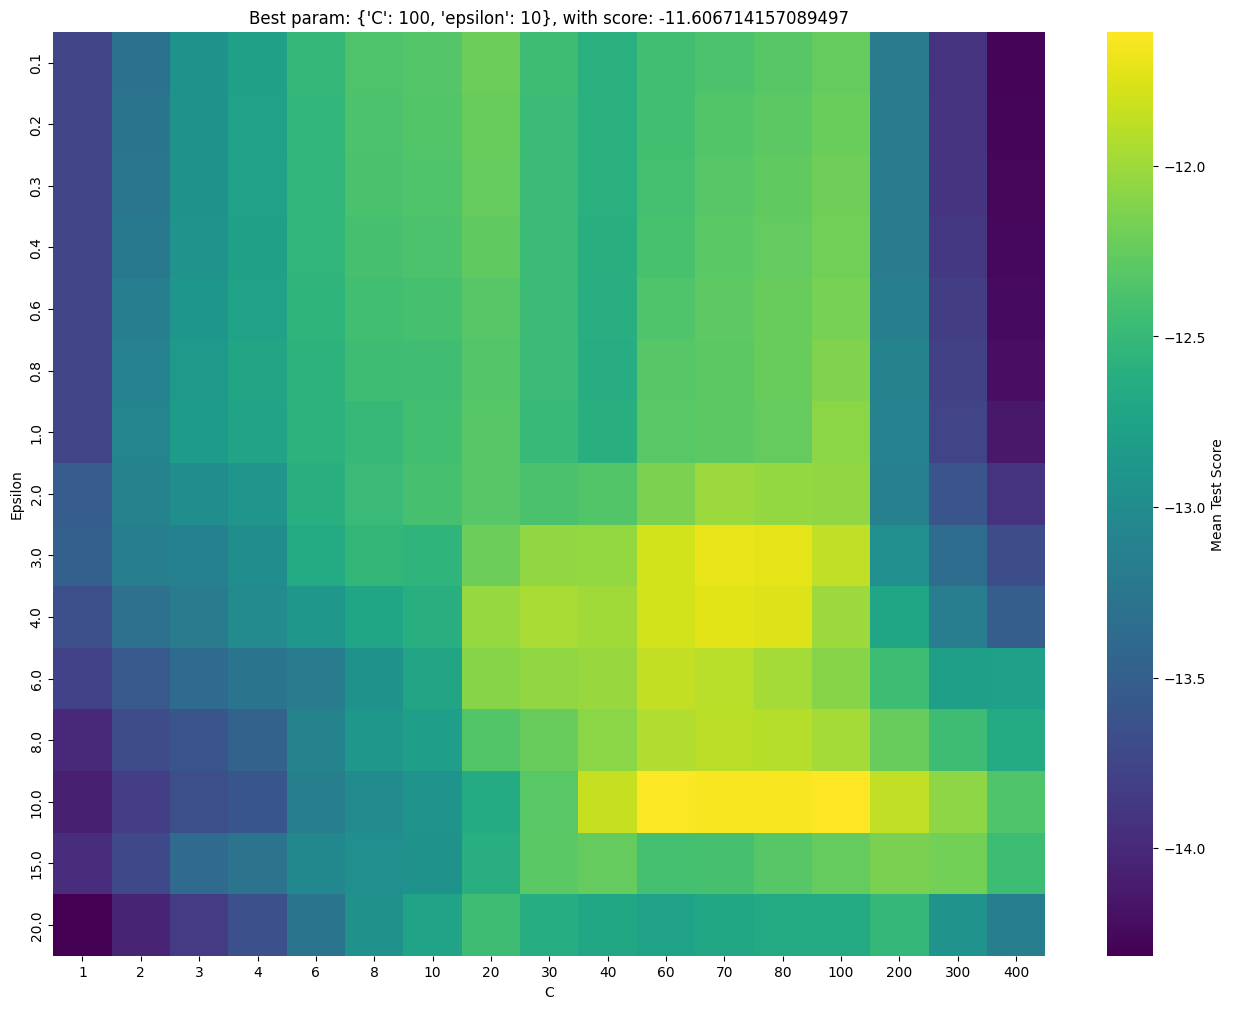

Best hyperparameters: {'C': 100, 'epsilon': 10}
With Score: -11.606714157089497


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


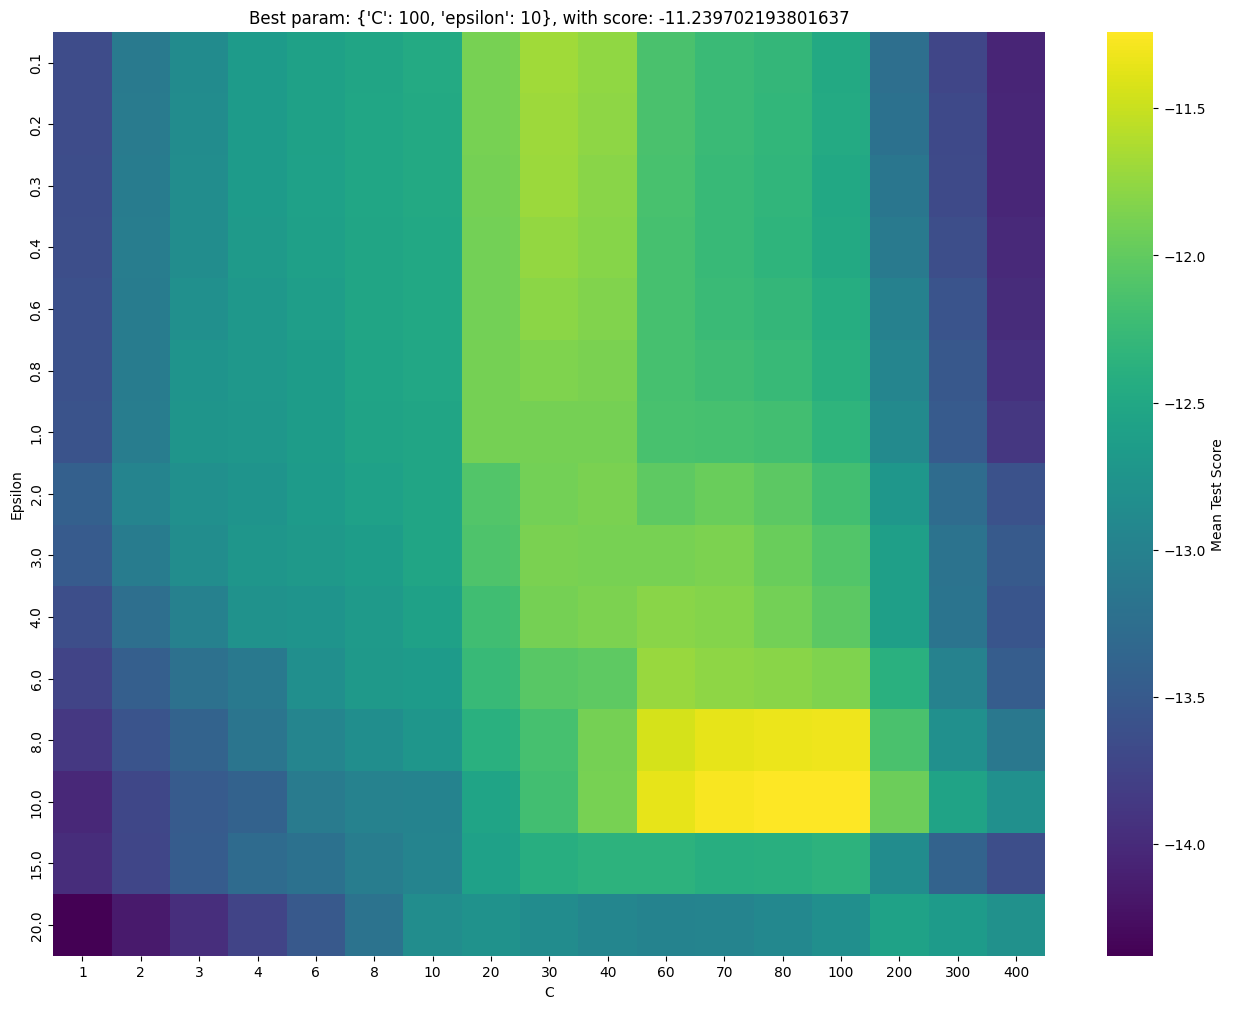

Best hyperparameters: {'C': 100, 'epsilon': 10}
With Score: -11.239702193801637


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


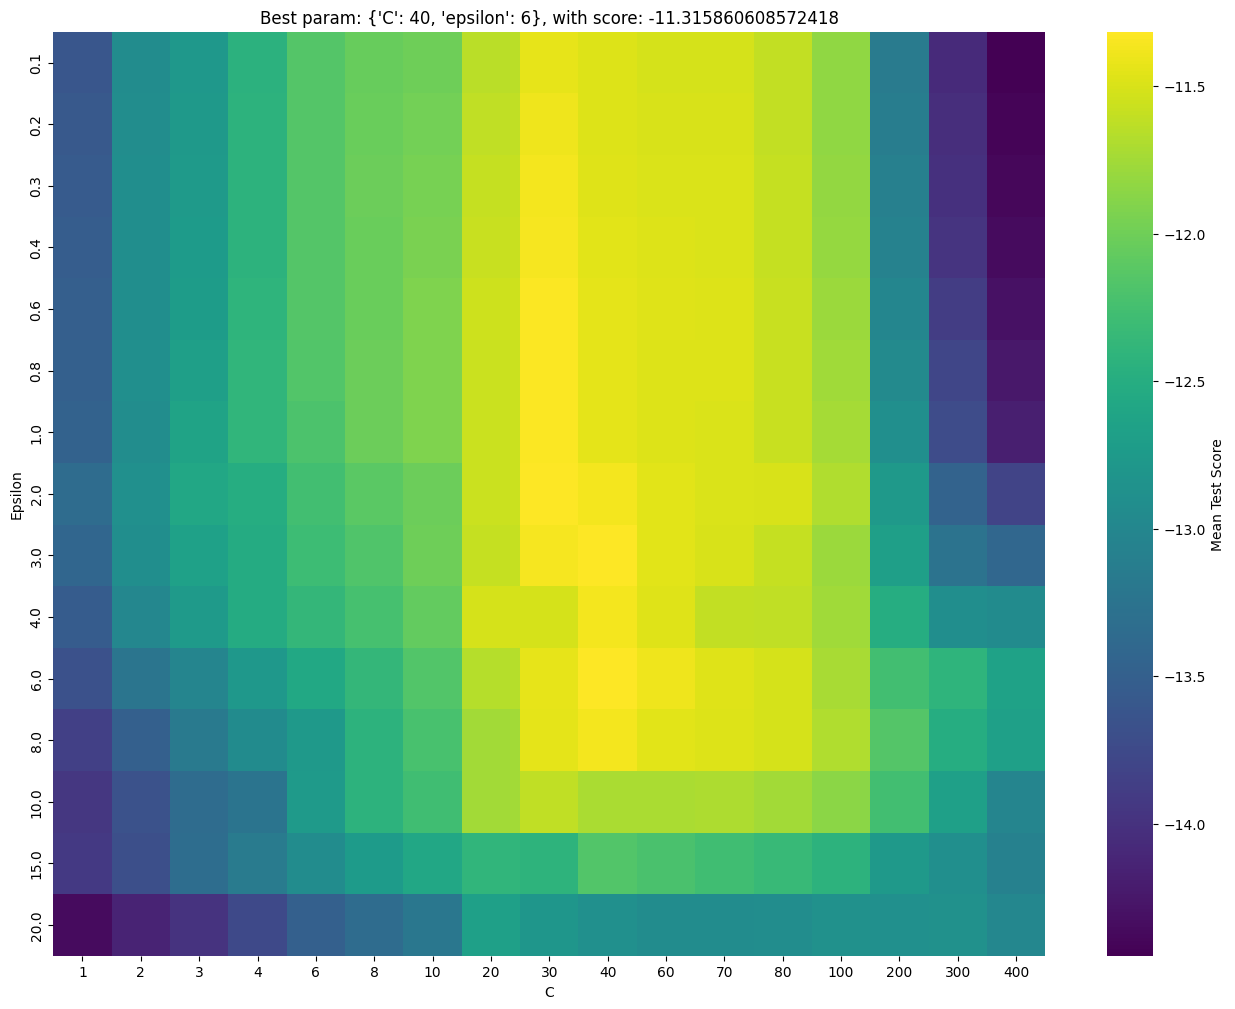

Best hyperparameters: {'C': 40, 'epsilon': 6}
With Score: -11.315860608572418


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


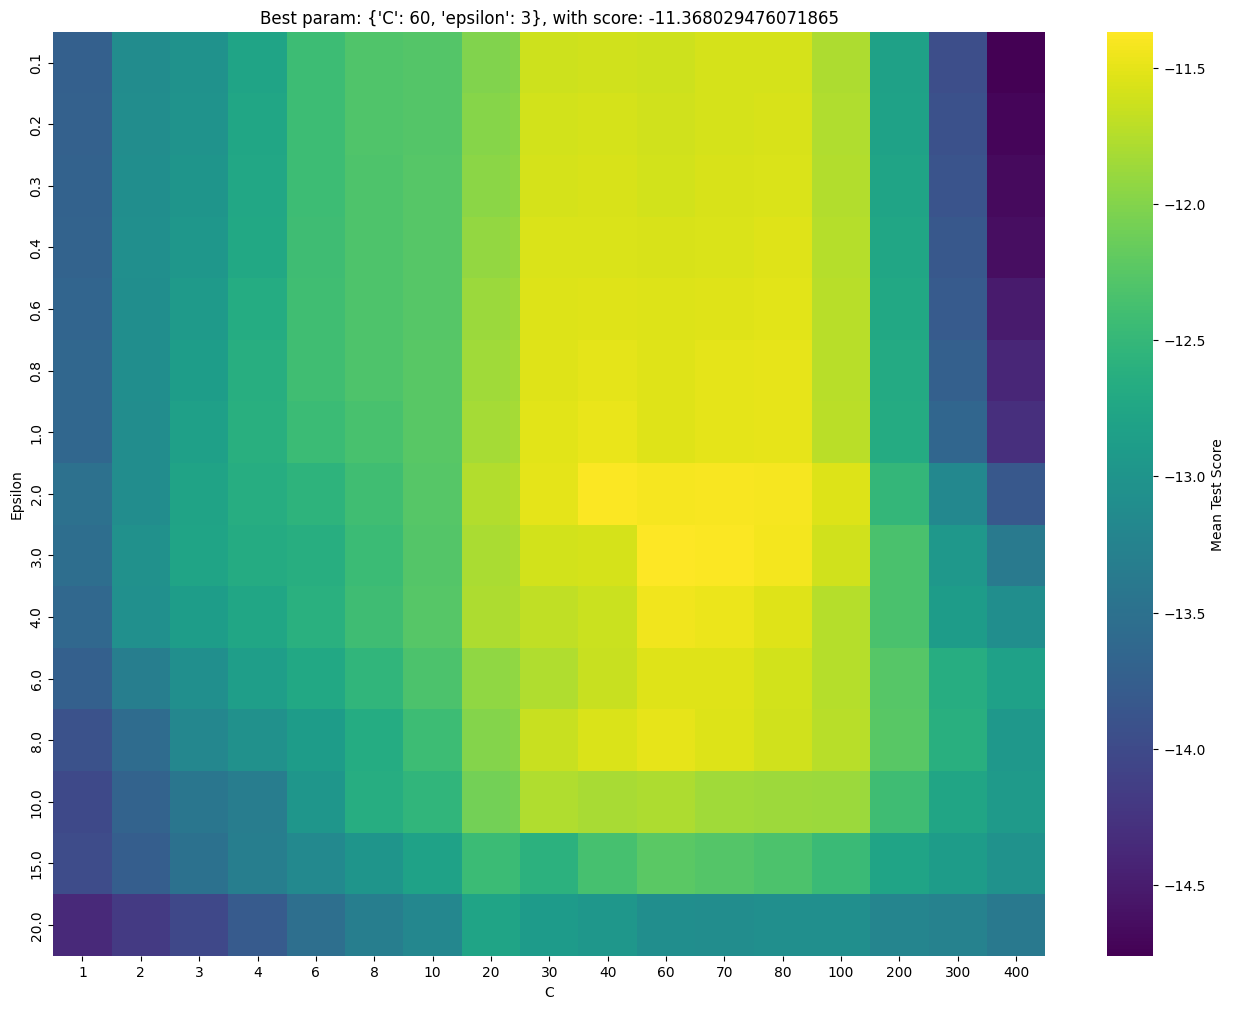

Best hyperparameters: {'C': 60, 'epsilon': 3}
With Score: -11.368029476071865


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


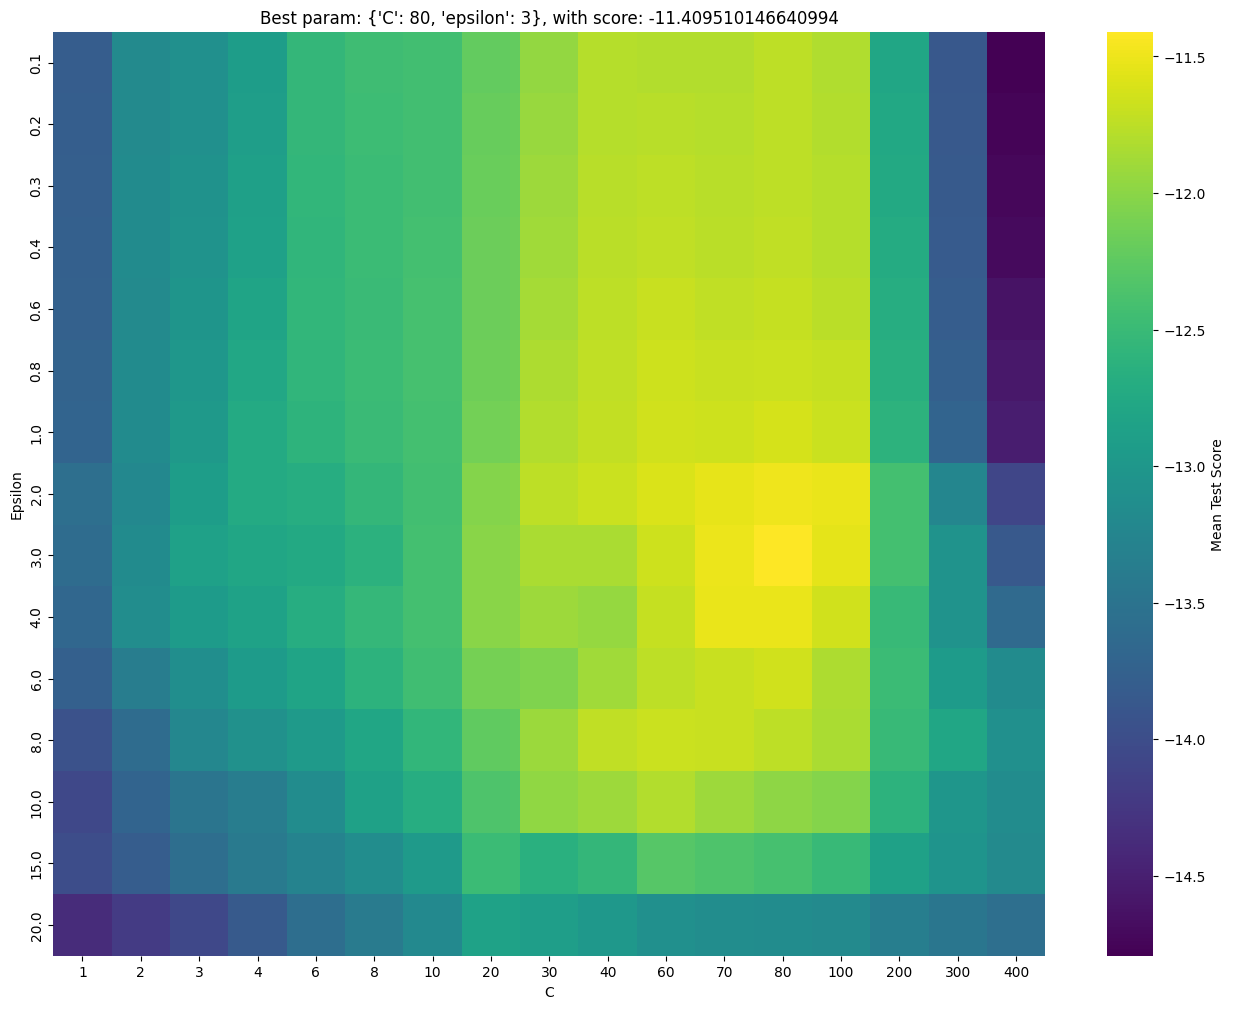

Best hyperparameters: {'C': 80, 'epsilon': 3}
With Score: -11.409510146640994


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


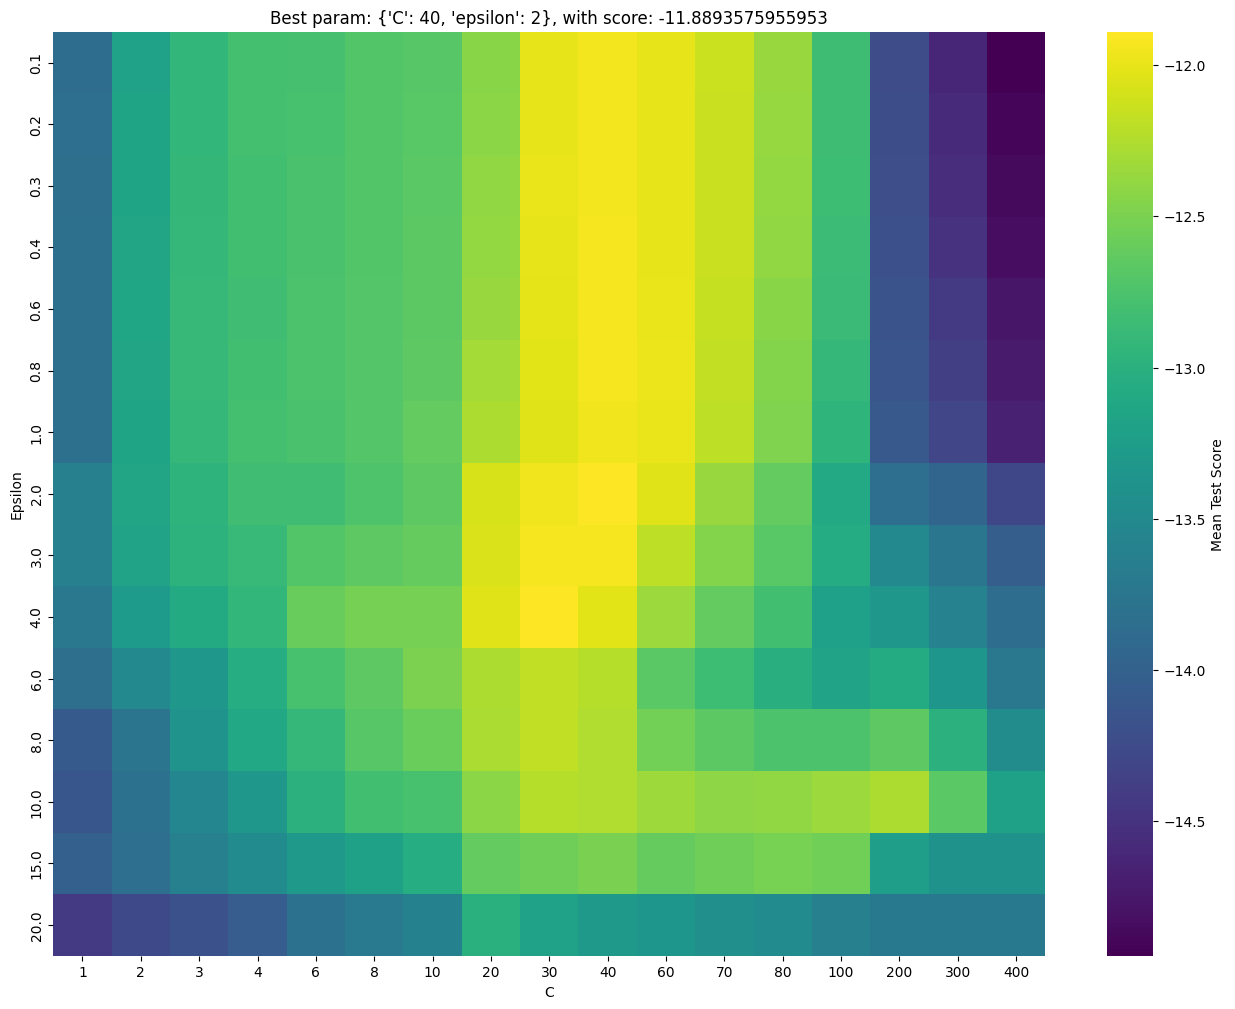

Best hyperparameters: {'C': 40, 'epsilon': 2}
With Score: -11.8893575955953


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


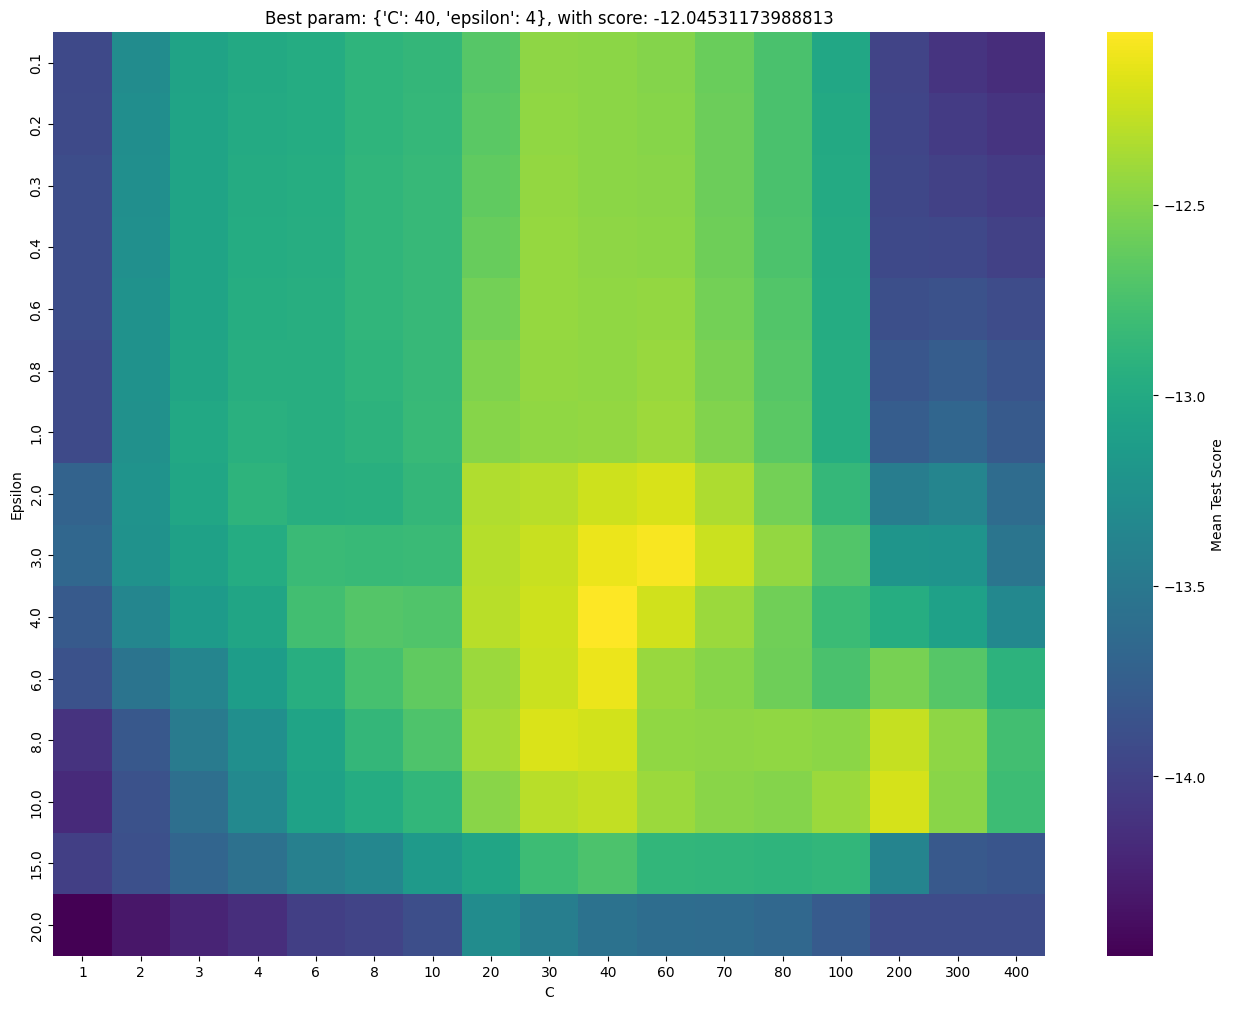

Best hyperparameters: {'C': 40, 'epsilon': 4}
With Score: -12.04531173988813


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


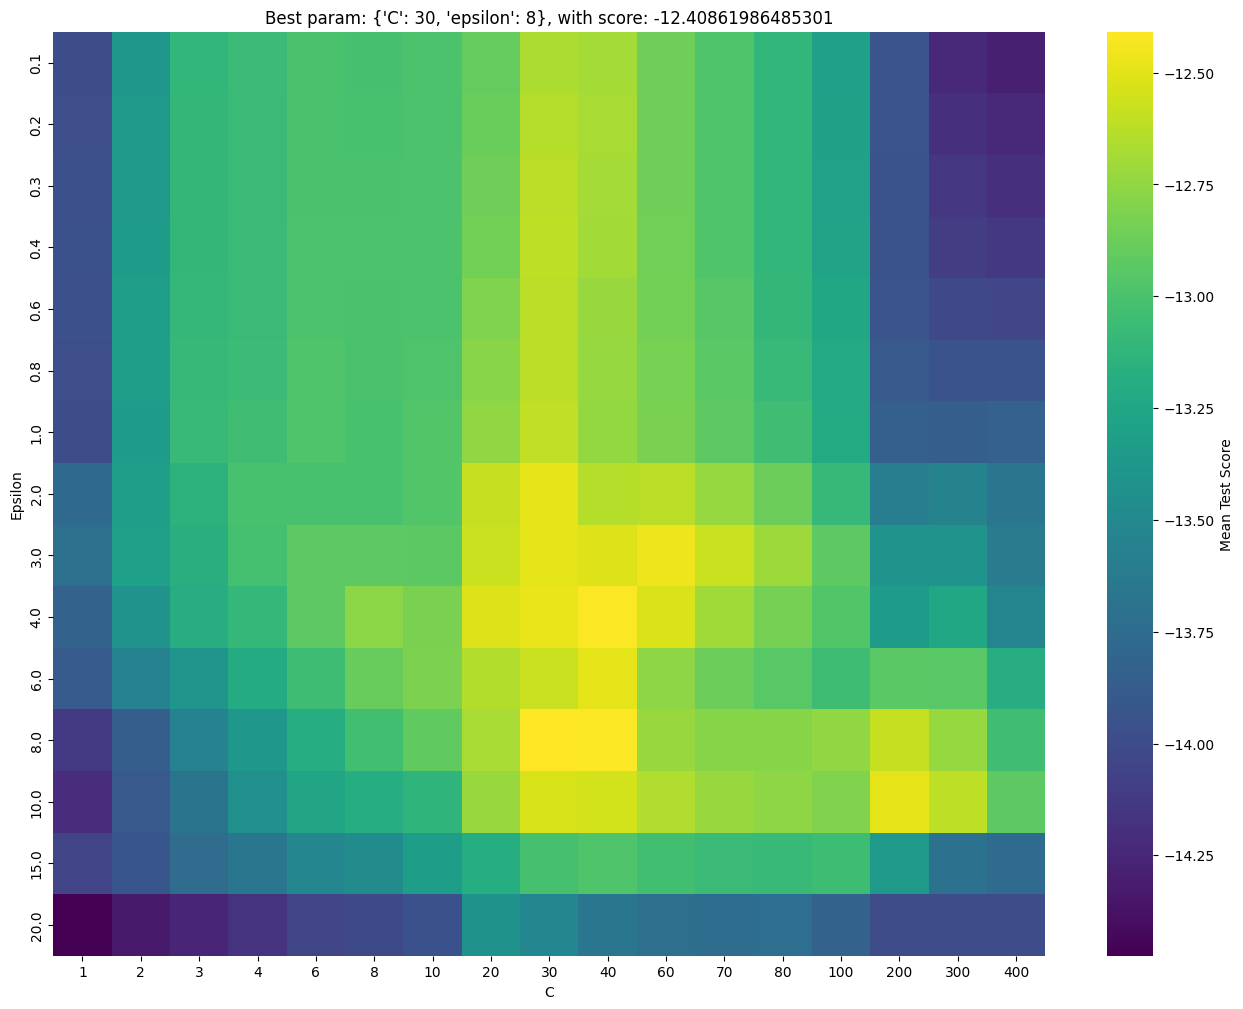

Best hyperparameters: {'C': 30, 'epsilon': 8}
With Score: -12.40861986485301


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


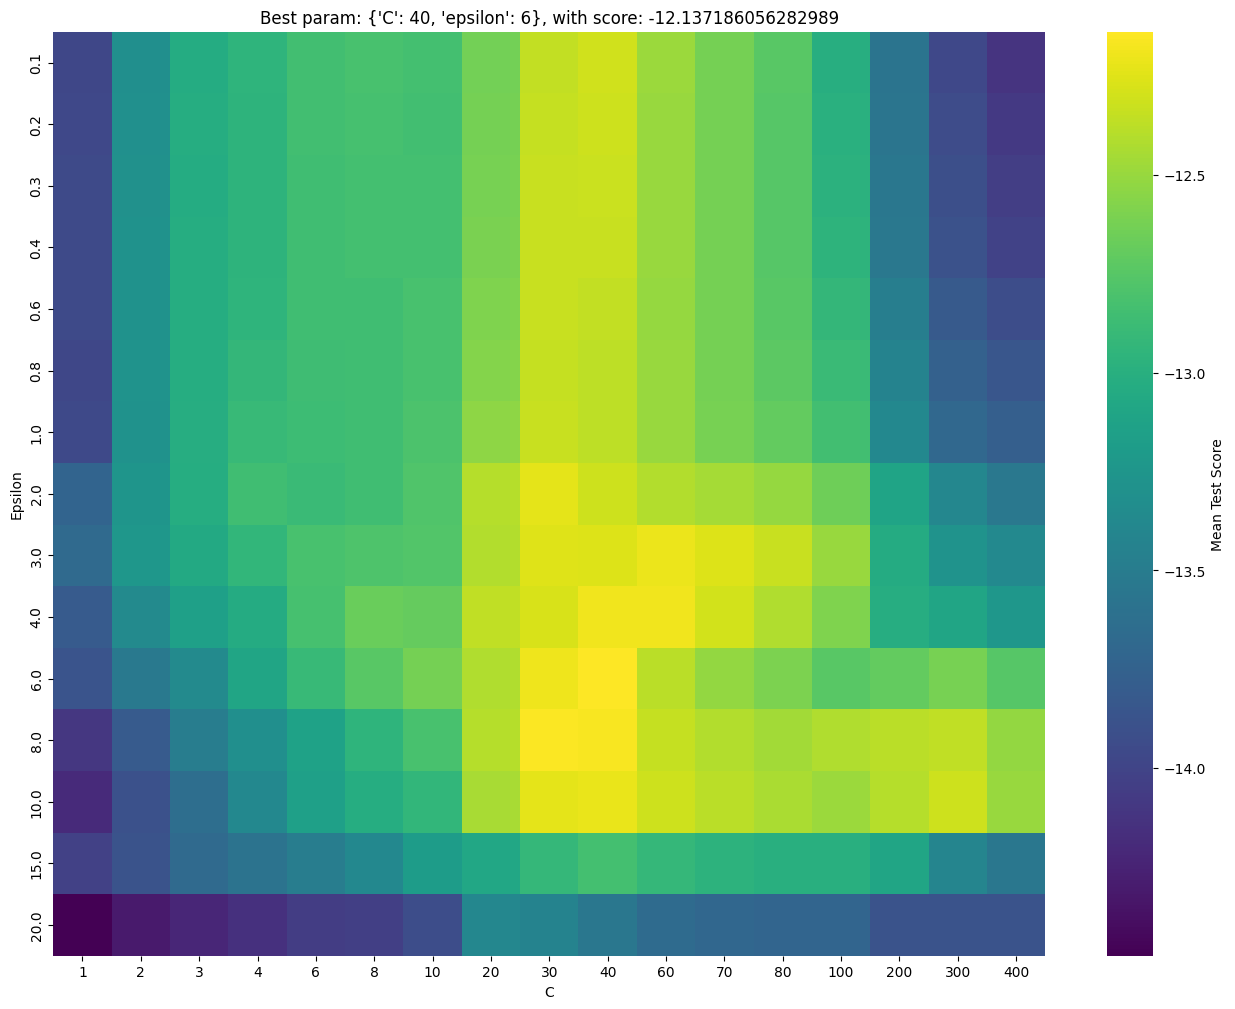

Best hyperparameters: {'C': 40, 'epsilon': 6}
With Score: -12.137186056282989


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


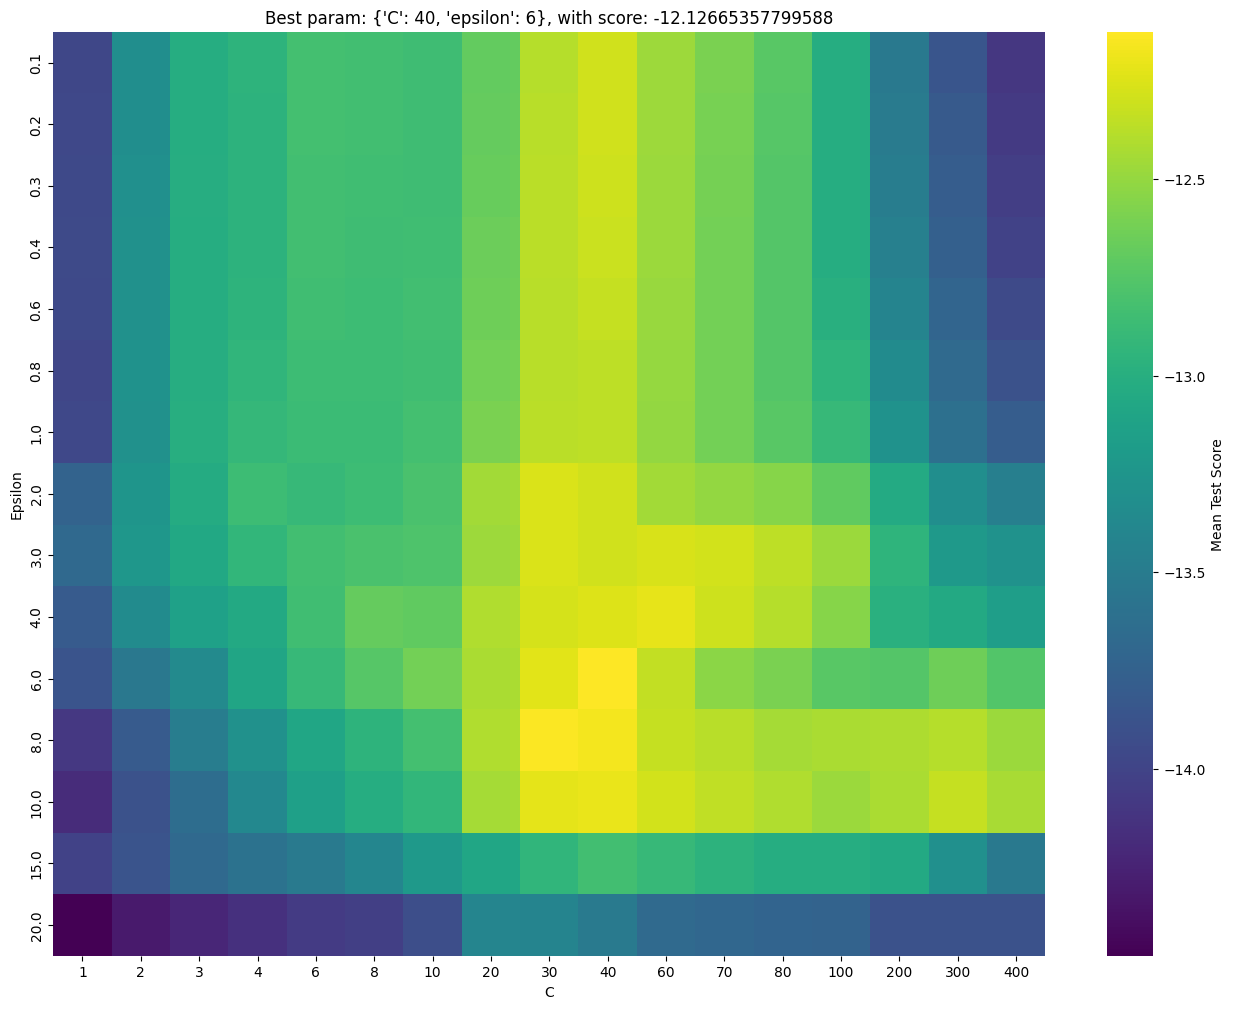

Best hyperparameters: {'C': 40, 'epsilon': 6}
With Score: -12.12665357799588


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


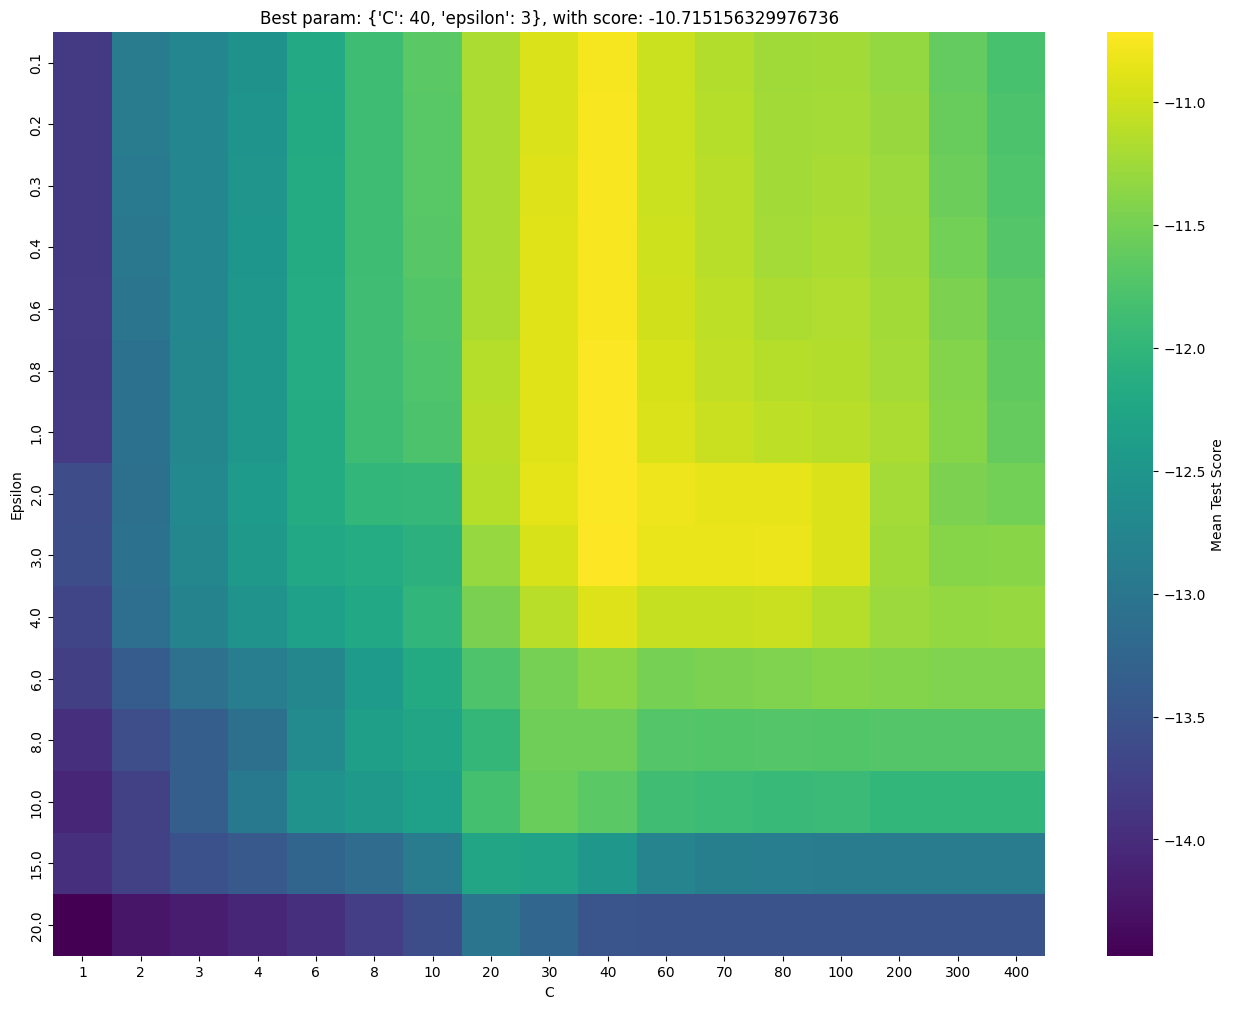

Best hyperparameters: {'C': 40, 'epsilon': 3}
With Score: -10.715156329976736


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


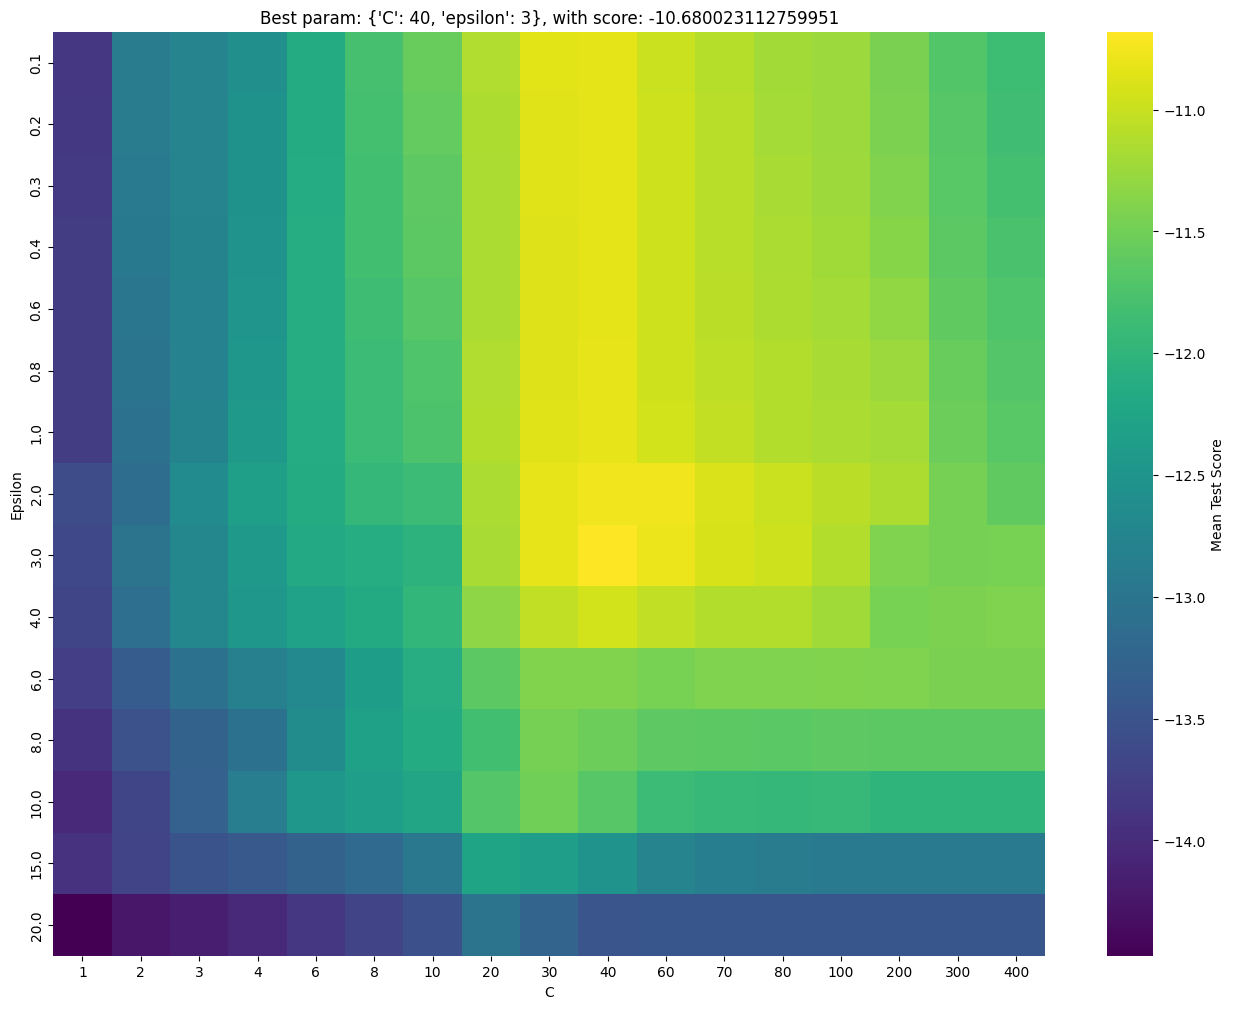

Best hyperparameters: {'C': 40, 'epsilon': 3}
With Score: -10.680023112759951


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


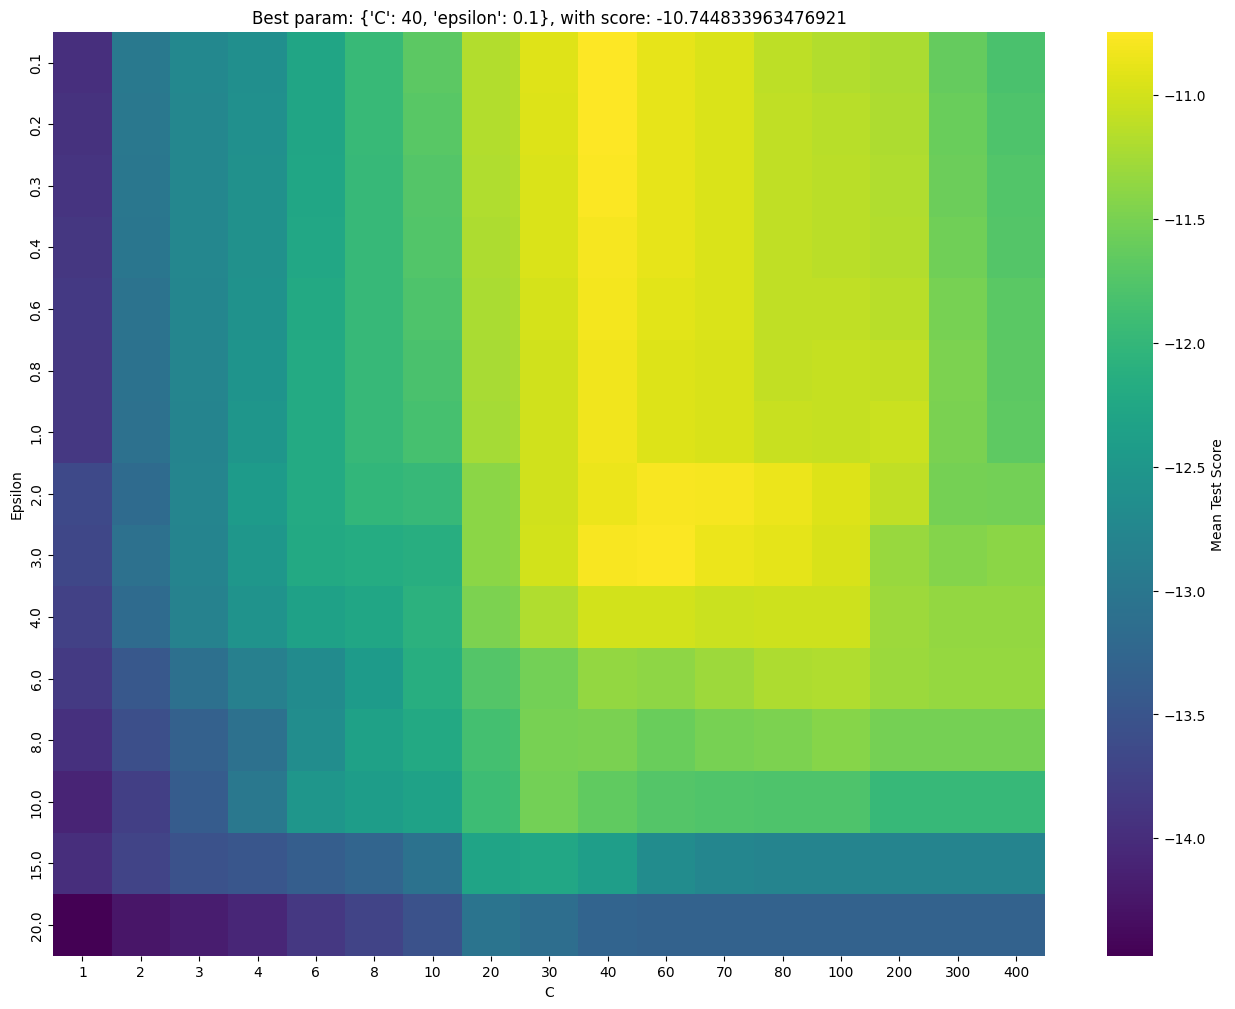

Best hyperparameters: {'C': 40, 'epsilon': 0.1}
With Score: -10.744833963476921


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


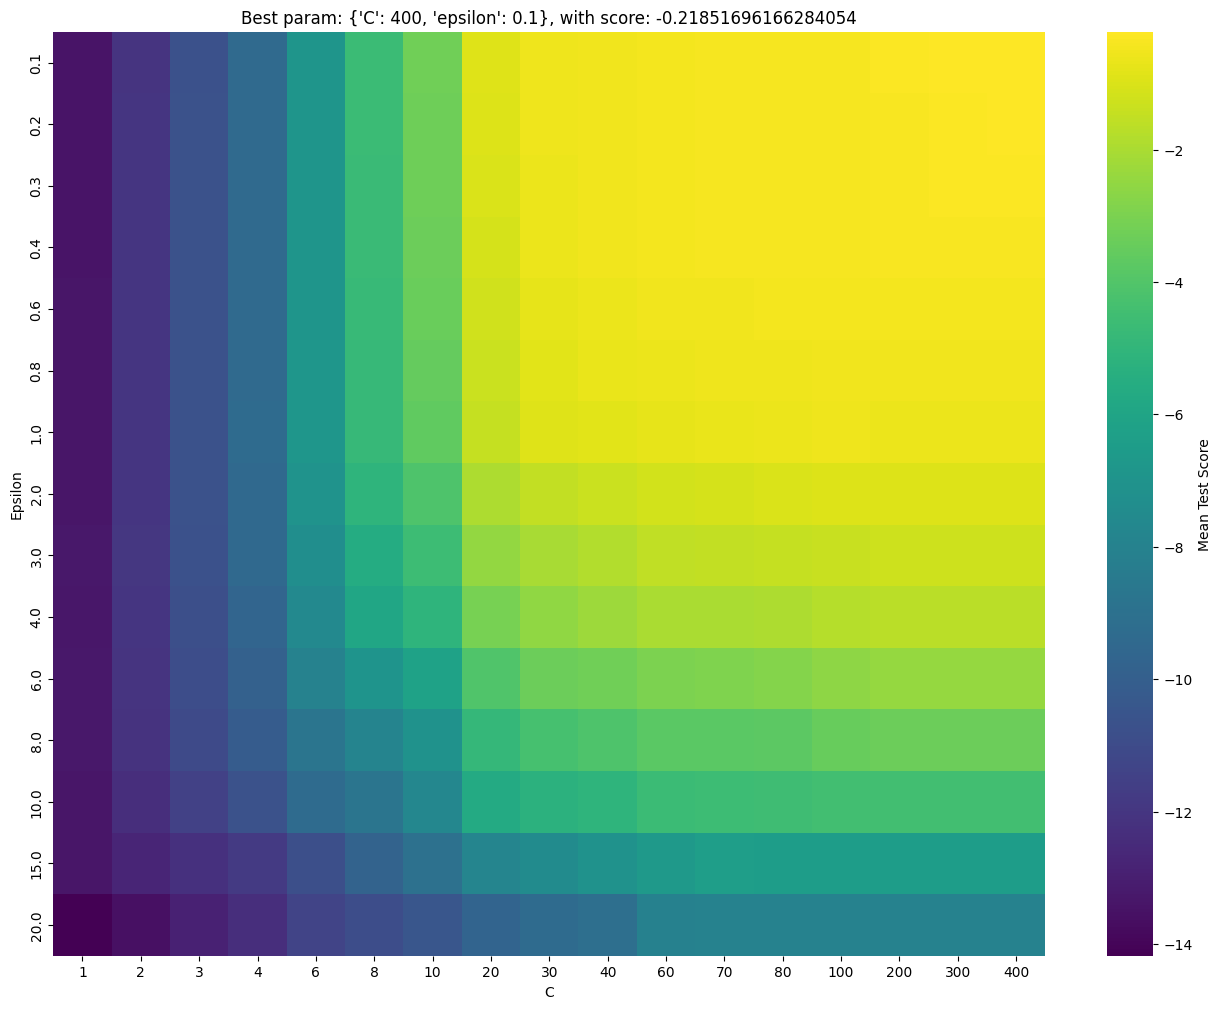

Best hyperparameters: {'C': 400, 'epsilon': 0.1}
With Score: -0.21851696166284054


C:\Users\ukisy\AppData\Local\Temp\ipykernel_13396\2620834416.py:16: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')


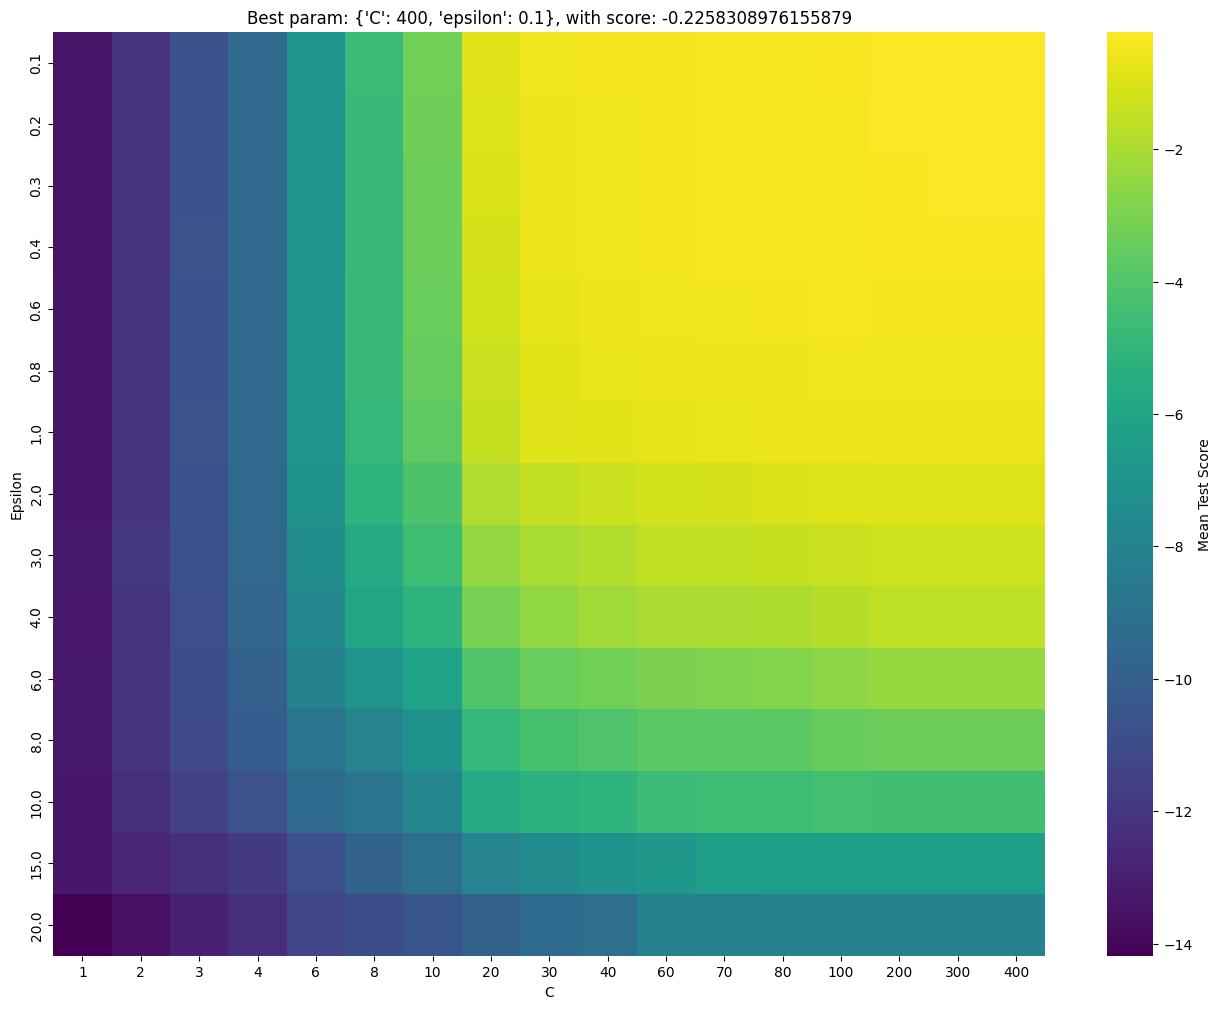

Best hyperparameters: {'C': 400, 'epsilon': 0.1}
With Score: -0.2258308976155879


In [13]:
import os
from joblib import load

systole_path = './grid-search-result/systole'
systole_feature_length = len([f for f in os.listdir(systole_path) if os.path.isfile(os.path.join(systole_path, f))])
for i in range(systole_feature_length):
  grid_search = load(f"{systole_path}/{i}.pkl")

  # Plot each model grid search

  # Get the results as a Pandas DataFrame
  results = pd.DataFrame(grid_search.cv_results_)

  # Reshape the results for heatmap
  heatmap_data = results.pivot(index='param_epsilon', columns='param_C', values='mean_test_score')

  # Plot the heatmap
  plt.figure(figsize=(16, 12))
  sns.heatmap(heatmap_data, cmap='viridis', fmt=".4f", cbar_kws={'label': 'Mean Test Score'})
  plt.title(f"Best param: {grid_search.best_params_}, with score: {grid_search.best_score_}")
  plt.xlabel('C')
  plt.ylabel('Epsilon')
  plt.show()

  # Print the best hyperparameters
  print("Best hyperparameters:", grid_search.best_params_)
  print("With Score:", grid_search.best_score_)


